In [1]:
from data_structures import *
from helpers import *
import matplotlib.pyplot as plt
import numpy as np

N = 50


In [2]:

def run_analysis(params, nx = None, ny = None):

    #Donner la possiblité de définir nx et ny indépendamment de n, sinon définition symmétrique sur n
    if nx is None:
        nx = params.n

    if ny is None:
        ny = params.n


    A, B = mdf_assemblage((0, params.L), (-params.H/2, params.H/2), nx, ny, params)
    T = np.linalg.solve(A, B)   # T de taille N = nx*ny

    x_mat, y_mat = position((0, params.L), (-params.H/2, params.H/2), nx, ny)
    #Reconstruction de la matrice température à partir du vecteur 1D T
    T_mat = vecteur_en_matrice(T, nx, ny)

    #Construction de la matrice vitesse (x car vy est nul)
    U_mat = np.zeros((ny, nx))
    for i in range(ny):
        for j in range(nx):
            U_mat[i, j] = vitesse(x_mat[i, j], y_mat[i, j], params)[0]

    resultats=Results(x_mat, y_mat, T_mat, U_mat)
    #Confusion je bois!
    #self est la référence de la classe Results dans Results, à l'extérieur on l'appelle resultats (le nom que tas choisi)
    resultats.y_limite_T=couches_limites(resultats,params)[0]
    resultats.y_limite_U=couches_limites(resultats,params)[1]
    resultats.y_limite_T_symm=couches_limites(resultats,params)[2]
    resultats.y_limite_U_symm=couches_limites(resultats,params)[3]
    return resultats

In [3]:
def plot(Results, note = ''):
    plt.figure(figsize=(12, 5))
    niveaux = 100  # nombre de niveaux de contour
    cf = plt.contourf(Results.x_mat, Results.y_mat, Results.T_mat, levels=niveaux)
    plt.colorbar(cf, label="Température [K]")
    # Couche limite thermique
    ax= plt.gca()
    ax.plot(Results.x_mat[0, :], Results.y_limite_T, 'r--', linewidth=2, label='Couche limite thermique')
    ax.plot(Results.x_mat[0, :], Results.y_limite_T_symm, 'r--', linewidth=2)


    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.title("Température dans la couche limite " + note)
    plt.tight_layout()
    plt.show()

    #Visulisation du champ de vitesse
    plt.figure(figsize=(12, 5))
    cf = plt.contourf(Results.x_mat, Results.y_mat, Results.U_mat, levels=niveaux)
    plt.colorbar(cf, label="Vitesse en x [m/s]")
    # Couche limite visqueuse
    ax= plt.gca()
    ax.plot(Results.x_mat[0, :], Results.y_limite_U, 'c--', linewidth=2, label='Couche limite visqueuse')
    ax.plot(Results.x_mat[0, :], Results.y_limite_U_symm, 'c--', linewidth=2)
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.title("Champ de vitesse en x dans la couche limite " + note)
    plt.tight_layout()
    plt.show()

In [4]:
# Définition des paramètres de base  j'ai rajouté n=50 ici pour qu'il soit fixe partout et modifiable à un seul endroit
params = Params(
    H = 0.001,
    mu = 0.001,
    rho = 1000,
    T_in = 298,
    T_w = 373,
    cp = 4186,
    k = 0.6,
    L = 1.0,
    U_in = 1.0,
    Ldev = 0.05,
    n=N
)

resultat = run_analysis(params)


In [5]:

def mdf_assemblage(X : tuple, Y : tuple, nx : int, ny : int, params : Params):
    """ Fonction assemblant la matrice A et le vecteur b

    Entrées:
        - X : Bornes du domaine en x, X = [x_min, x_max]
        - Y : Bornes du domaine en y, Y = [y_min, y_max]
        - nx : Discrétisation de l'espace en x (nombre de points)
        - ny : Discrétisation de l'espace en y (nombre de points)
        - params : Structure de données contenant les paramètres physiques du problème

    Sorties (dans l'ordre énuméré ci-bas):
        - A : Matrice (array)
        - b : Vecteur (array)
    """
    

    x_mat, y_mat = position(X, Y, nx, ny)
    

    dx = (X[1] - X[0]) / (nx - 1)
    dy = (Y[1] - Y[0]) / (ny - 1)

    #Simplification des paramètres
    const = params.rho * params.cp /2/params.k/dx

    N = nx * ny
    #Initialisation des matrices et vecteurs
    A = np.zeros((N, N))
    B = np.zeros(N)

    # Dirichlet 
    T_edge = params.T_w
    T_entrée = params.T_in


    for i in range(ny):
        for j in range(nx):
            k = idx(i, j, ny)

            #Détection des bords
            gauche_lim   = (j == 0)
            droite_lim  = (j == nx - 1)
            haut_lim    = (i == 0)         
            bas_lim = (i == ny - 1)

            # Supposer que les conditions T_w appliqué en haut et bas sont prioritaires?
            
            if gauche_lim:
                A[k, k] = 1.0
                B[k] = T_entrée
            elif droite_lim:
                pass
                #TODO : Faire la condition de Neumann à droite ici 
                A[k, k] = 3/2/dx
                k_gauche = idx(i, j - 1, ny)
                k_gauche2 = idx(i, j - 2, ny)
                A[k, k_gauche] = -2/dx
                A[k, k_gauche2] = 1/2/dx
                B[k] = 0
            elif haut_lim or bas_lim:
                    A[k, k] = 1.0
                    B[k] = T_edge

            else:
                # ---- Interior / Neumann edges ----
                u = vitesse(x_mat[i, j], y_mat[i, j], params)[0]
                #évaluation de v même si on ne l'utilise pas, vitesse nulle

                #possible utilisation du programme dans le futur avec v non nul
                v = vitesse(x_mat[i, j], y_mat[i, j], params)[1]

                #Évaluation des indices k pour les voisins
                k_gauche = idx(i, j - 1, ny)
                k_droite = idx(i, j + 1, ny)
                k_haut = idx(i - 1, j, ny)
                k_bas = idx(i + 1, j, ny)

                # Assemblage de la matrice A et du vecteur b
                A[k, k] = 2/dx/dx + 2/dy/dy
                A[k, k_gauche] = -const*u - 1/dx/dx
                A[k, k_droite] = const*u - 1/dx/dx
                A[k, k_bas] = -1/dy/dy
                A[k, k_haut] = -1/dy/dy
                B[k] = 0
    return A, B


In [6]:

nx, ny = 50, 50


A, B = mdf_assemblage((0, params.L), (-params.H/2, params.H/2), nx, ny, params)
T = np.linalg.solve(A, B)   # T de taille N = nx*ny

x_mat, y_mat = position((0, params.L), (-params.H/2, params.H/2), nx, ny)
T_mat = vecteur_en_matrice(T, nx, ny)



In [7]:
#Construction de la matrice vitesses (x car vy est nul)
U_mat = np.zeros((ny, nx))
for i in range(ny):
    for j in range(nx):
        U_mat[i, j] = vitesse(x_mat[i, j], y_mat[i, j], params)[0]

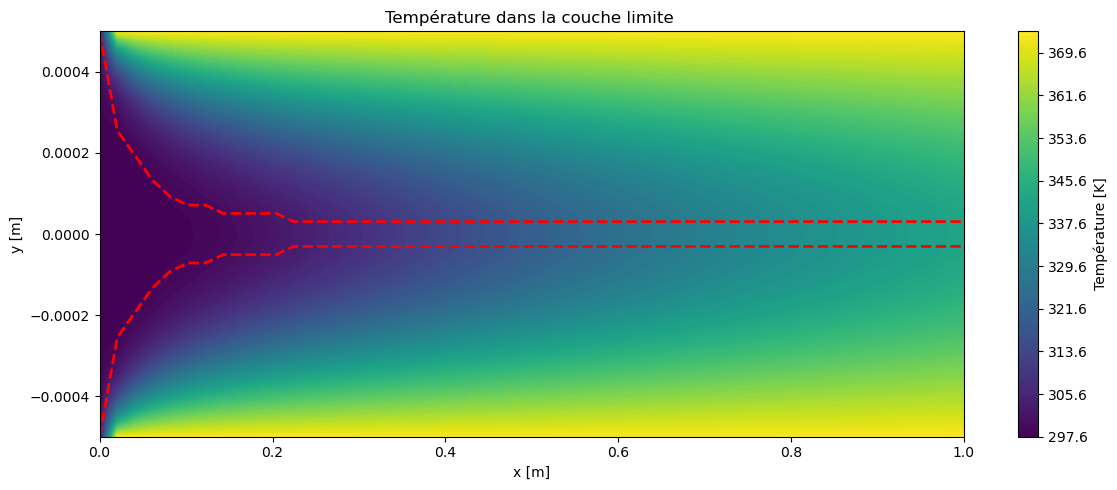

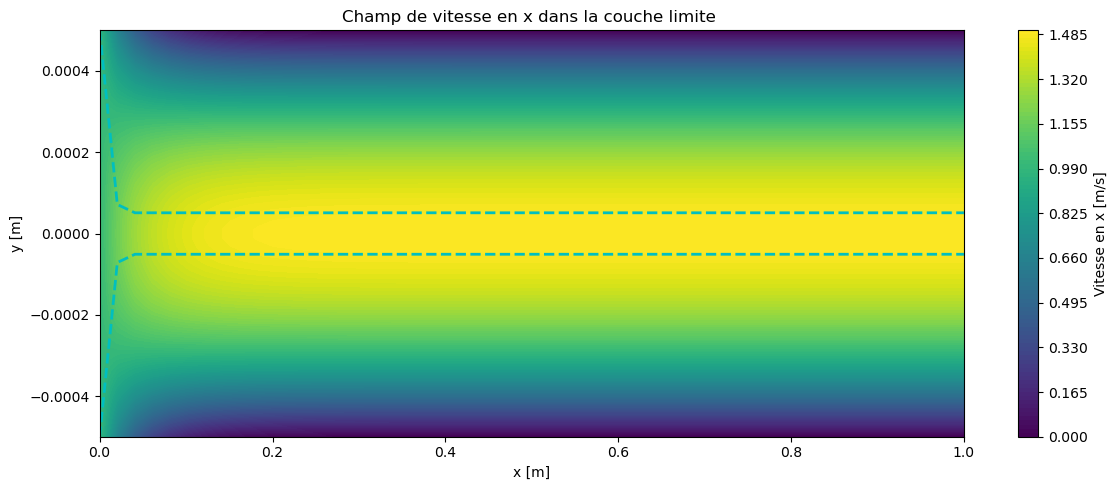

In [8]:
plot(resultat)

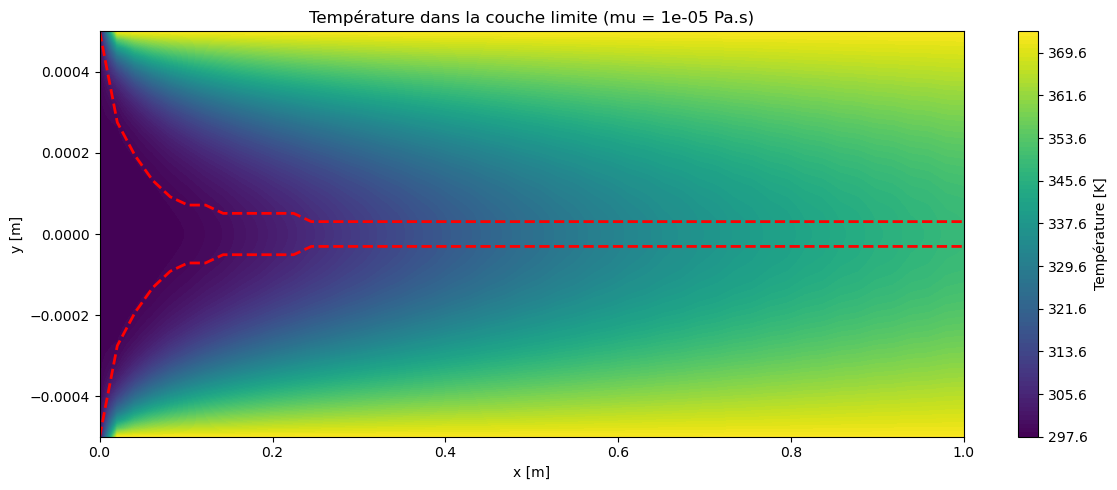

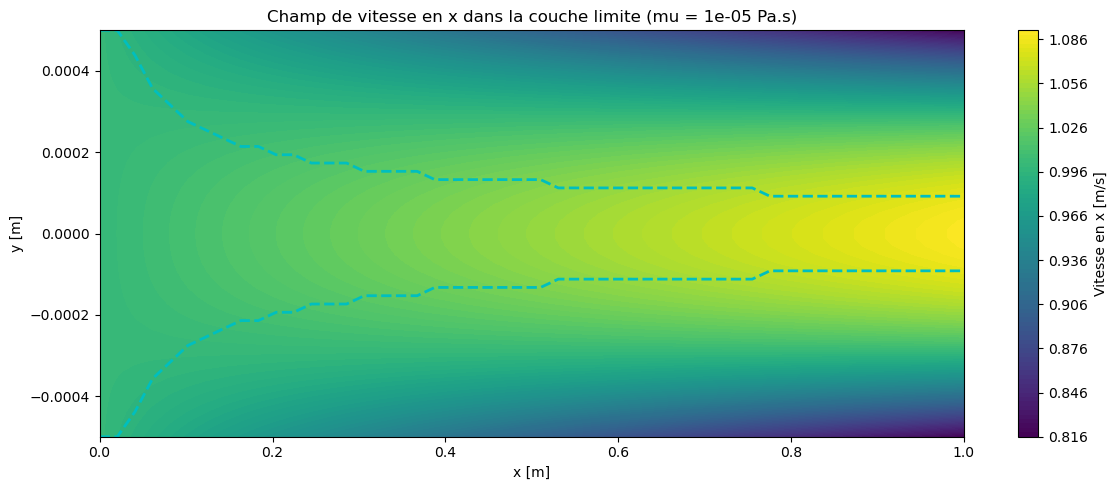

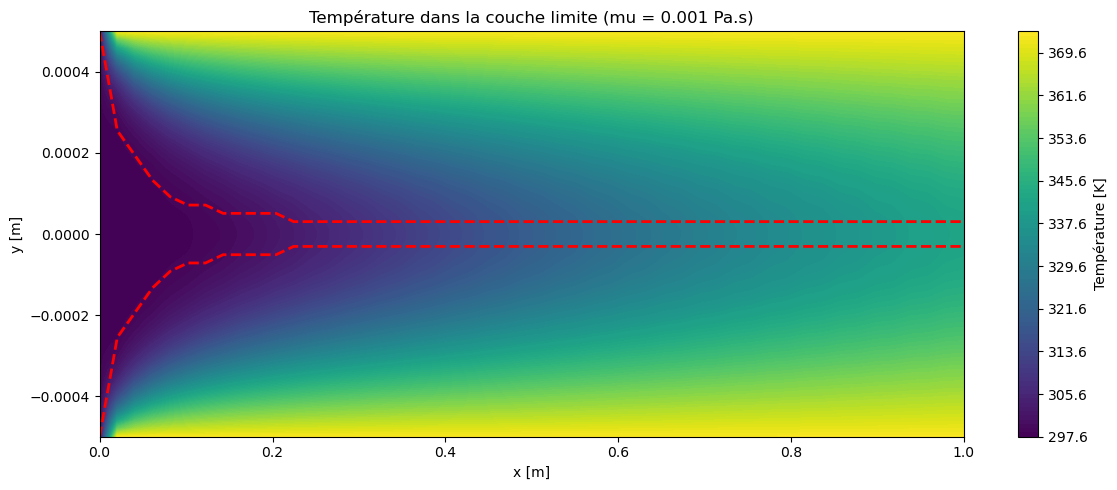

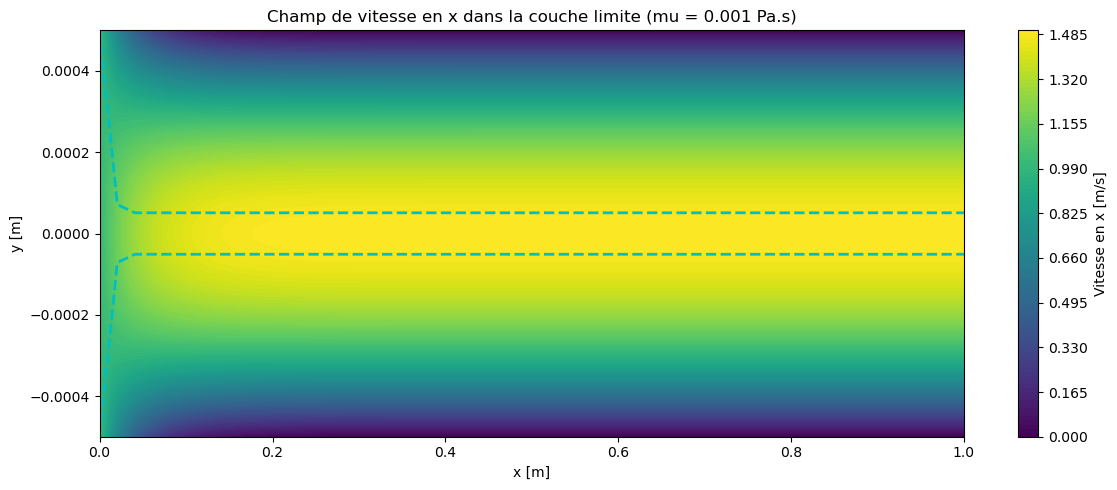

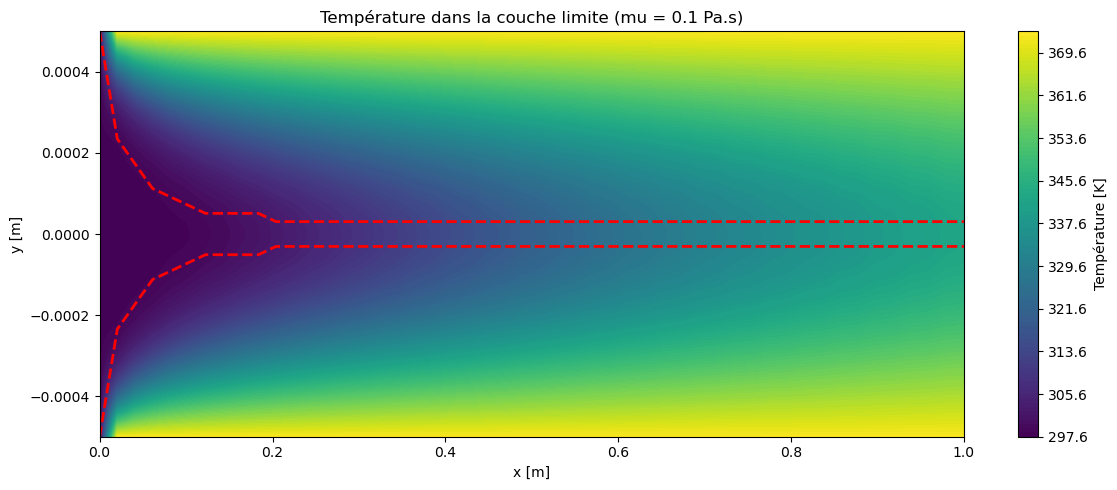

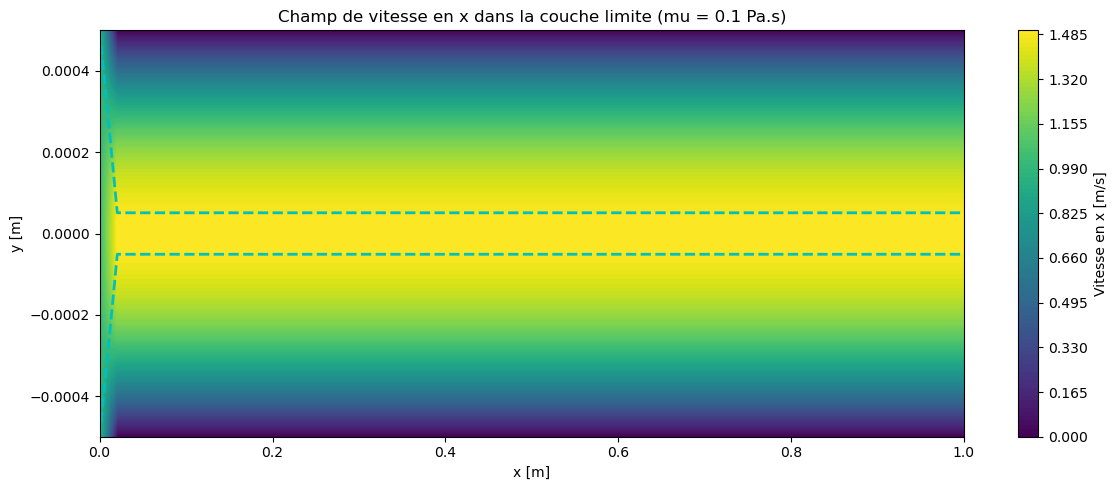

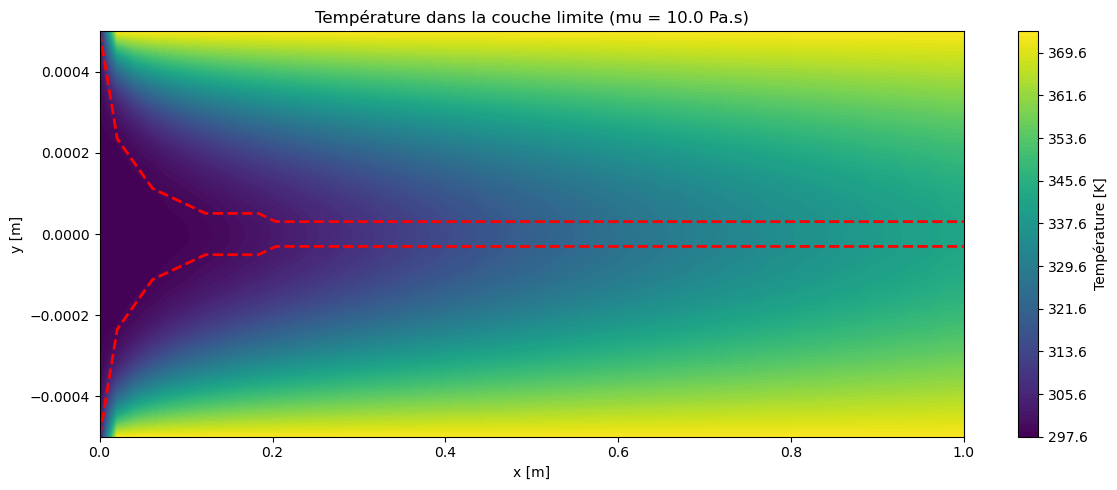

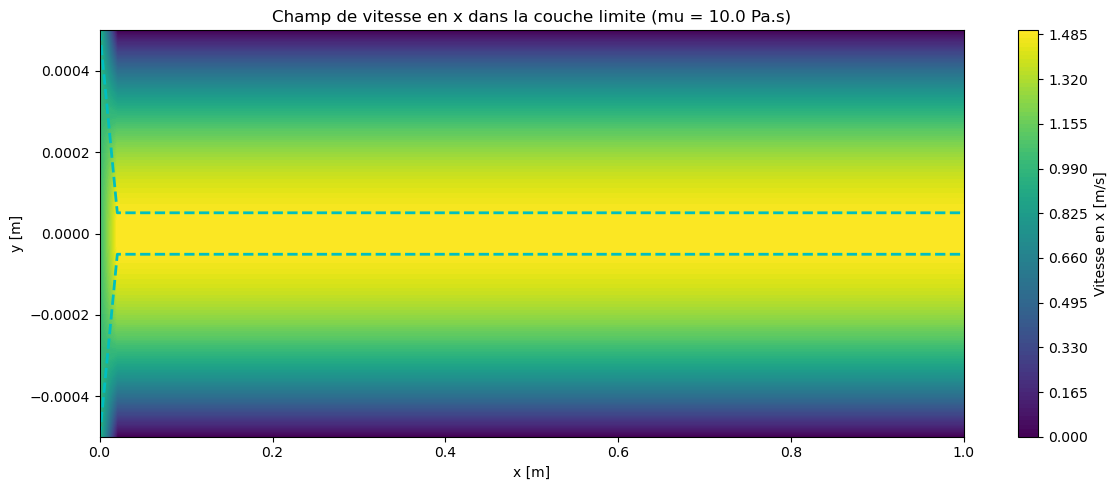

In [9]:
params = Params(
    H = 0.001,
    mu = 0.001,
    rho = 1000,
    T_in = 298,
    T_w = 373,
    cp = 4186,
    k = 0.6,
    L = 1.0,
    U_in = 1.0,
    Ldev = 0.05,
    n = N
)

#Étude de l'influence du nombre de prant
#On choisi de faire varier mu
mu_vals = [0.00001, 0.001, 0.1, 10.0]

for mu in mu_vals:
    params.mu = mu
    
    resultat = run_analysis(params)
    note = f"(mu = {mu} Pa.s)"
    plot(resultat, note)

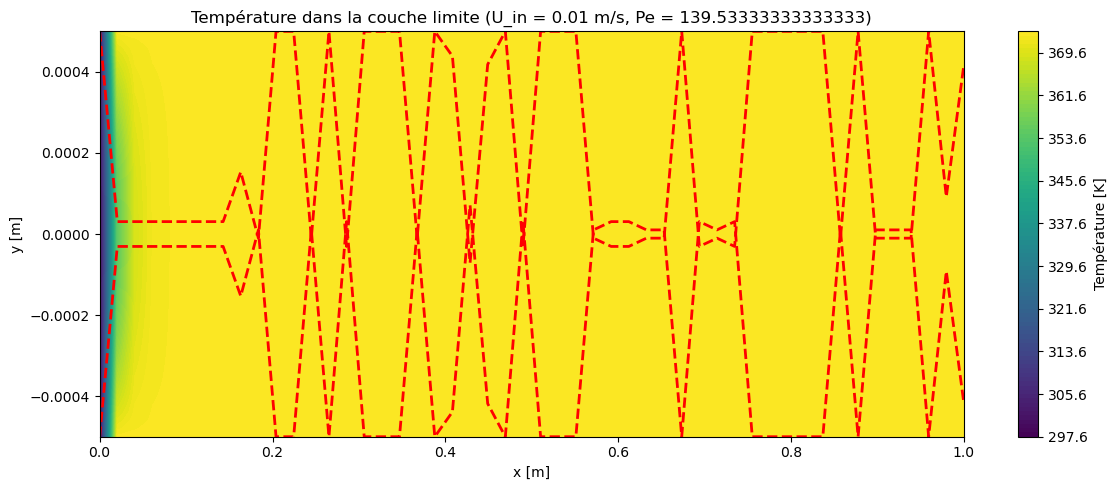

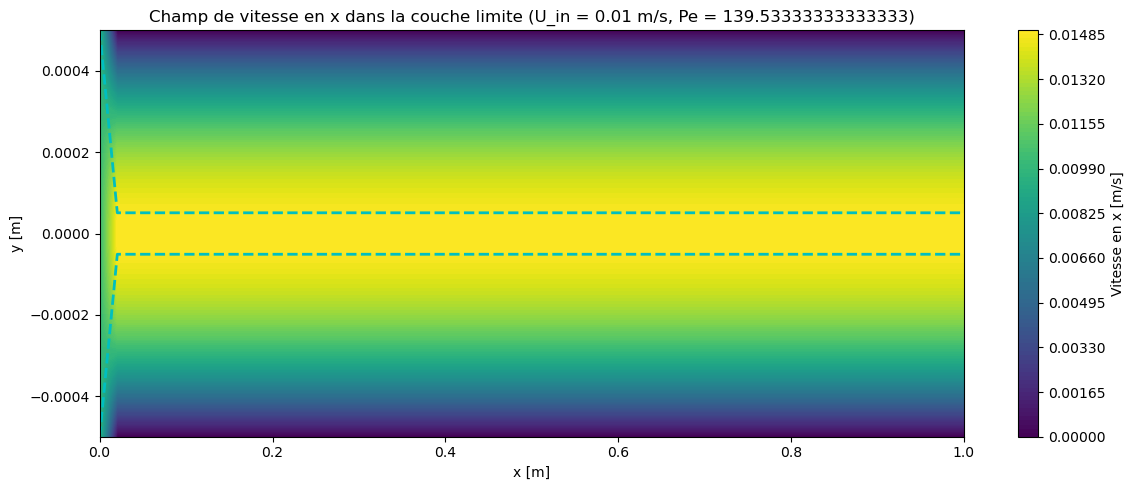

[-5.00000000e-04 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05
 -1.53061224e-04  1.02040816e-05 -5.00000000e-04 -5.00000000e-04
  1.02040816e-05 -5.00000000e-04  3.06122449e-05 -5.00000000e-04
 -5.00000000e-04 -5.00000000e-04  1.02040816e-05 -5.00000000e-04
 -4.38775510e-04  7.14285714e-05 -4.18367347e-04 -5.00000000e-04
  3.06122449e-05 -5.00000000e-04 -5.00000000e-04 -5.00000000e-04
  1.02040816e-05  3.06122449e-05  3.06122449e-05  1.02040816e-05
  1.02040816e-05 -5.00000000e-04  3.06122449e-05  1.02040816e-05
  3.06122449e-05 -5.00000000e-04 -5.00000000e-04 -5.00000000e-04
 -5.00000000e-04 -5.00000000e-04  1.02040816e-05 -5.00000000e-04
  1.02040816e-05  1.02040816e-05  1.02040816e-05 -5.00000000e-04
 -9.18367347e-05 -4.18367347e-04]


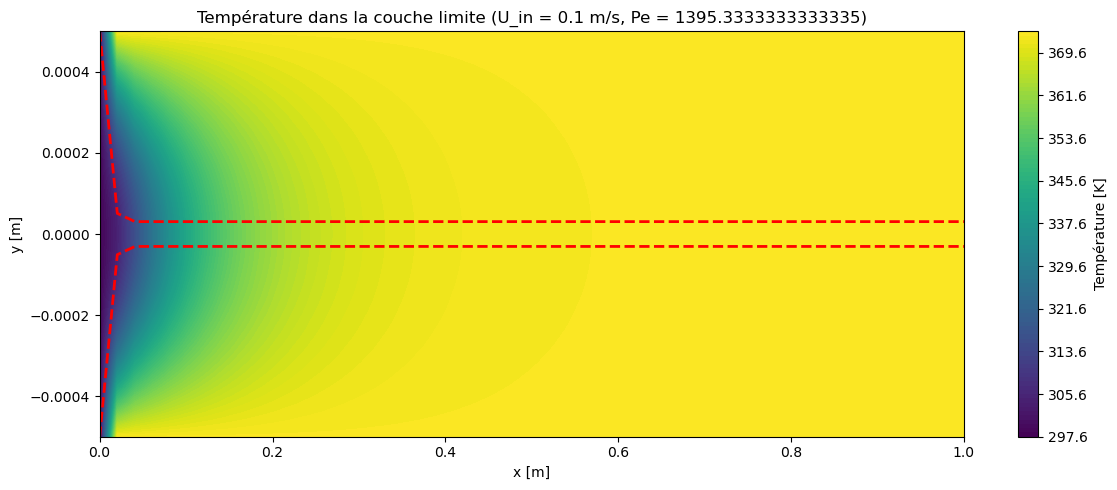

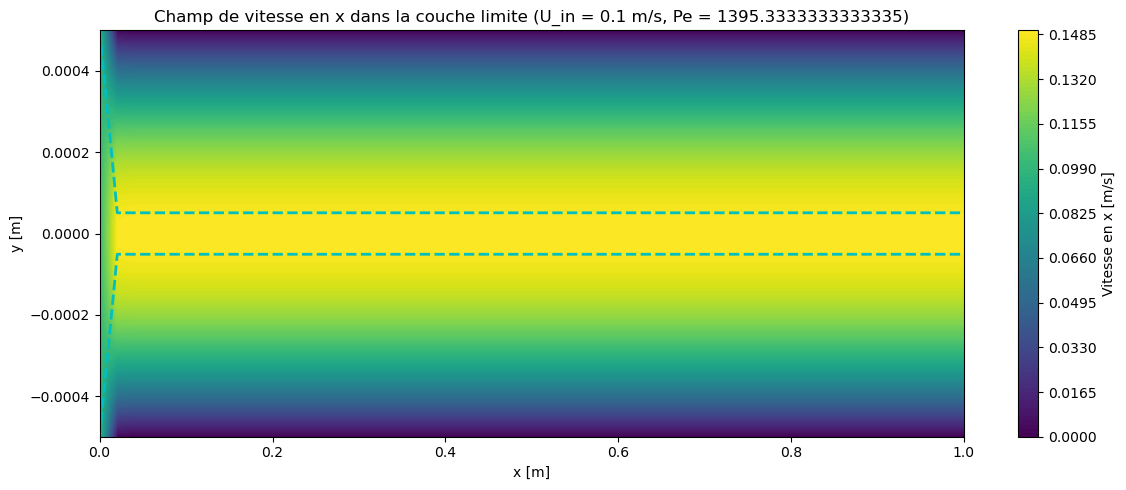

[-5.00000000e-04 -5.10204082e-05 -3.06122449e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05]


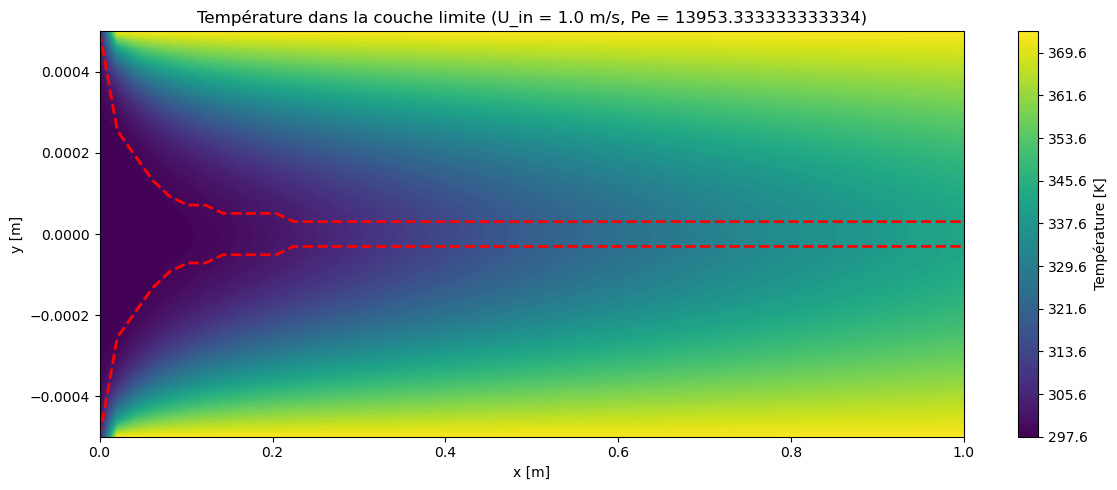

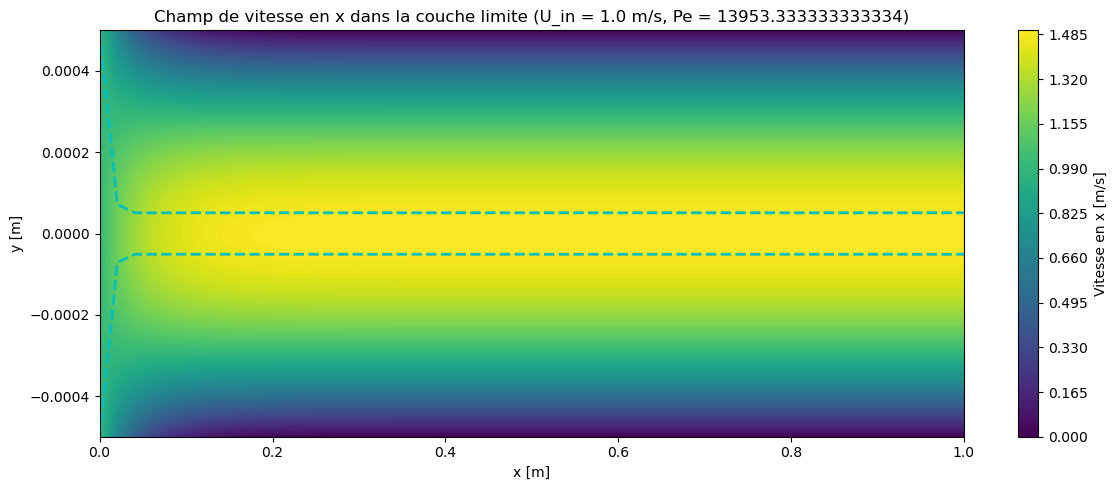

[-5.00000000e-04 -2.55102041e-04 -1.93877551e-04 -1.32653061e-04
 -9.18367347e-05 -7.14285714e-05 -7.14285714e-05 -5.10204082e-05
 -5.10204082e-05 -5.10204082e-05 -5.10204082e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05 -3.06122449e-05
 -3.06122449e-05 -3.06122449e-05]


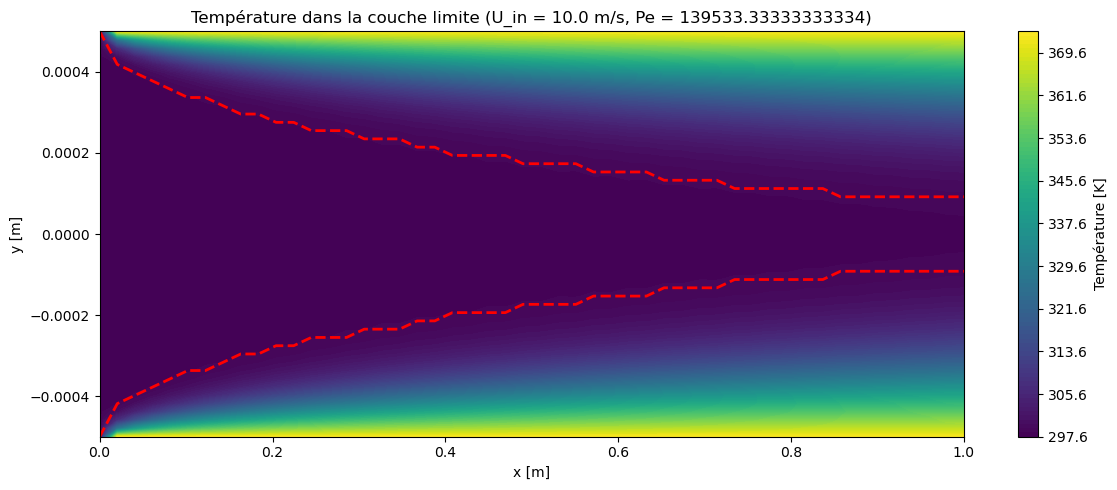

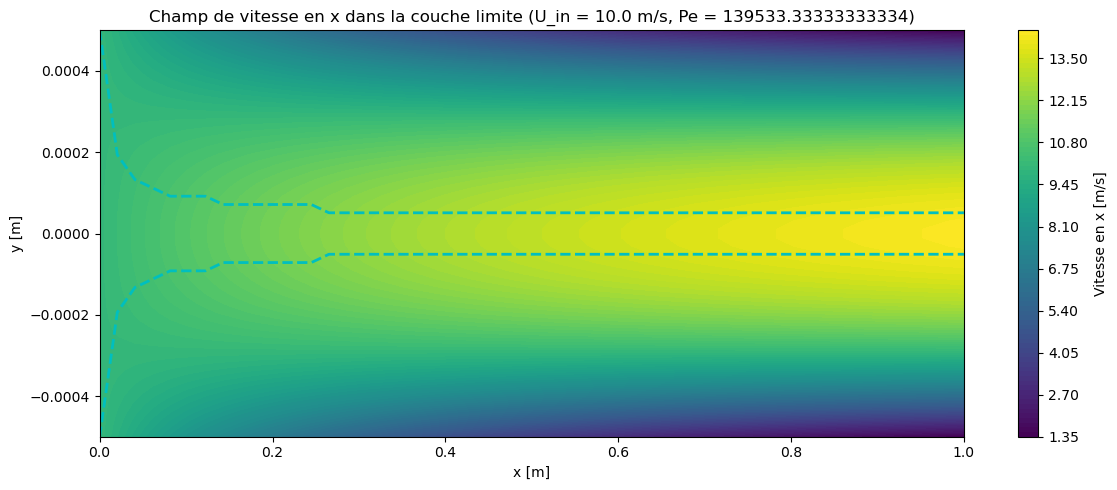

[-5.00000000e-04 -4.18367347e-04 -3.97959184e-04 -3.77551020e-04
 -3.57142857e-04 -3.36734694e-04 -3.36734694e-04 -3.16326531e-04
 -2.95918367e-04 -2.95918367e-04 -2.75510204e-04 -2.75510204e-04
 -2.55102041e-04 -2.55102041e-04 -2.55102041e-04 -2.34693878e-04
 -2.34693878e-04 -2.34693878e-04 -2.14285714e-04 -2.14285714e-04
 -1.93877551e-04 -1.93877551e-04 -1.93877551e-04 -1.93877551e-04
 -1.73469388e-04 -1.73469388e-04 -1.73469388e-04 -1.73469388e-04
 -1.53061224e-04 -1.53061224e-04 -1.53061224e-04 -1.53061224e-04
 -1.32653061e-04 -1.32653061e-04 -1.32653061e-04 -1.32653061e-04
 -1.12244898e-04 -1.12244898e-04 -1.12244898e-04 -1.12244898e-04
 -1.12244898e-04 -1.12244898e-04 -9.18367347e-05 -9.18367347e-05
 -9.18367347e-05 -9.18367347e-05 -9.18367347e-05 -9.18367347e-05
 -9.18367347e-05 -9.18367347e-05]


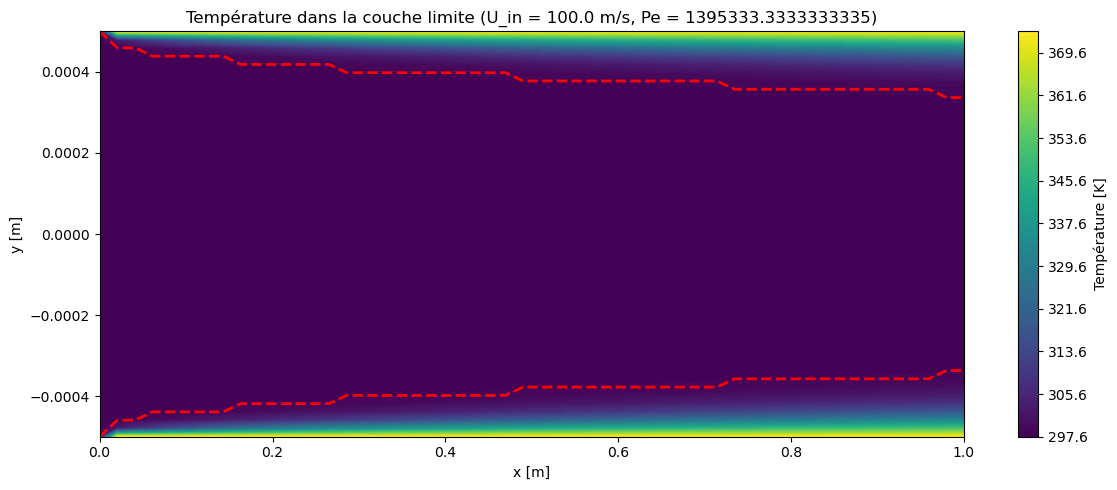

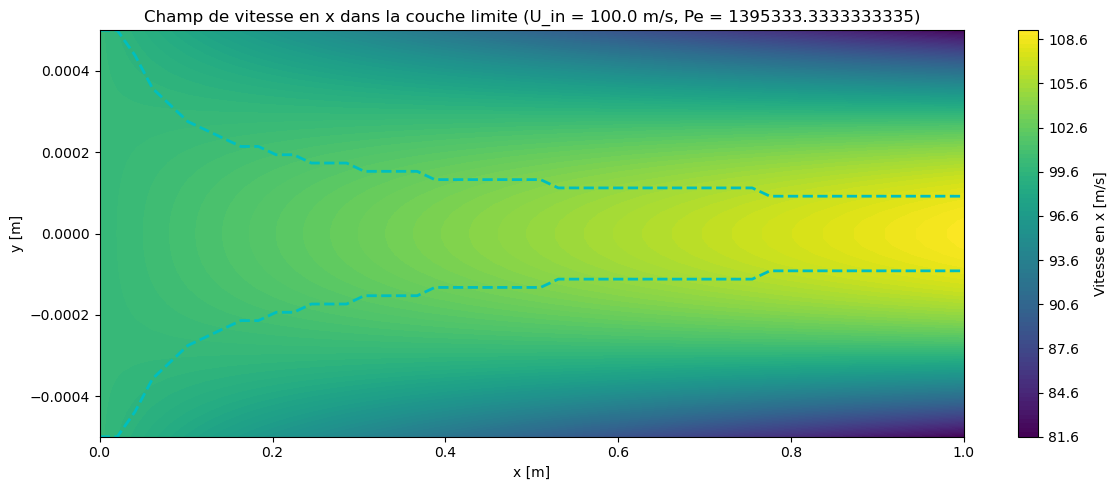

[-0.0005     -0.00045918 -0.00045918 -0.00043878 -0.00043878 -0.00043878
 -0.00043878 -0.00043878 -0.00041837 -0.00041837 -0.00041837 -0.00041837
 -0.00041837 -0.00041837 -0.00039796 -0.00039796 -0.00039796 -0.00039796
 -0.00039796 -0.00039796 -0.00039796 -0.00039796 -0.00039796 -0.00039796
 -0.00037755 -0.00037755 -0.00037755 -0.00037755 -0.00037755 -0.00037755
 -0.00037755 -0.00037755 -0.00037755 -0.00037755 -0.00037755 -0.00037755
 -0.00035714 -0.00035714 -0.00035714 -0.00035714 -0.00035714 -0.00035714
 -0.00035714 -0.00035714 -0.00035714 -0.00035714 -0.00035714 -0.00035714
 -0.00033673 -0.00033673]


In [ ]:
#Étude de l'influence du nombre de peclet
#On choisi de faire varier k
params = Params(
    H = 0.001,
    mu = 0.001,
    rho = 1000,
    T_in = 298,
    T_w = 373,
    cp = 4186,
    k = 0.6,
    L = 1.0,
    U_in = 1.0,
    Ldev = 0.05,
    n = N
)

'''k_vals = [0.01, 0.1, 1.0, 10.0, 100.0]

for k in k_vals:
    params.k = k
    Pe = 2*params.rho * params.cp * params.U_in * params.H / params.k
    resultat = run_analysis(params, n=50)
    note = f"(k = {k} W/m.K, Pe = {Pe})"
    plot(resultat, note)'''


u_vals = [0.01, 0.1, 1.0, 10.0, 100.0]

for u in u_vals:
    params.U_in = u
    Pe = 2*params.rho * params.cp * params.U_in * params.H / params.k
    resultat = run_analysis(params)
    note = f"(U_in = {params.U_in} m/s, Pe = {Pe:.2f})"
    plot(resultat, note)
    print(resultat.y_limite_T)